# Analyzing reuse of posters

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from urllib.parse import unquote
import re
import os
import json
from scipy import stats
import time
from collections import Counter

## Global helper functions

In [2]:
_DOI_PATTERN = re.compile(
    r"""
    (?P<doi>                                  # capture group "doi"
        10\.\d{4,9}                           # directory indicator: 10.<4-9 digits>
        /                                     # slash
        [^\s"'<>\]]+                          # suffix: anything except whitespace/quotes/brackets
    )
    """,
    re.IGNORECASE | re.VERBOSE,
)

# Normalize dois, makes it easier to deduplicate citations
def _norm_doi(s):
    
    if not isinstance(s, str):
        return ""

    # Strip whitespace and decode any %-escapes first (handles %2F etc.)
    s_clean = unquote(s.strip())
    if not s_clean:
        return ""

    # Work in lowercase for stable matching
    s_lower = s_clean.lower()
    
    # Search for a DOI substring anywhere in the string
    m = _DOI_PATTERN.search(s_lower)
    if not m:
        return ""

    doi = m.group("doi").strip()

    return doi

## Create combined metadata file for reuse analysis

In [17]:
def finalize_df(df):
    
    bool_cols = [c for c in df.columns if c.startswith("has_") or c.startswith("is_")]
    count_cols = [c for c in df.columns if c.endswith("_count")]
    float_cols = [c for c in df.columns if c.endswith("_percentage")]
    str_cols = [
        "doi", "doi_url", "doi_norm", "repository_url", "license_name",
        "creation_date", "other_dates", "files", "repository"
    ]
    year_cols = ["creation_year"]

    # Ensure columns exist
    for c in str_cols + bool_cols + count_cols + float_cols:
        if c not in df.columns:
            df[c] = pd.NA

    df[bool_cols] = df[bool_cols].astype("boolean")
    df[count_cols] = df[count_cols].astype("Int64")
    df[float_cols] = df[float_cols].astype("Float64")
    df[str_cols] = df[str_cols].astype("string")
    df[year_cols] = df[year_cols].astype("Int64")

    # views/downloads int
    for c in ["views", "downloads", "citations"]:
        if c in df.columns:
            df[c] = df[c].astype("Int64")

    return df

In [18]:
# Load Data
df_zenodo = pd.read_csv("inputs/dataset/derivative/poster-metadata/zenodo.csv")
df_figshare = pd.read_csv("inputs/dataset/derivative/poster-metadata/figshare.csv")

# Combine and add normalized doi (better for comparison)
df = pd.concat([df_zenodo, df_figshare], ignore_index=True)
df['doi_norm'] = df['doi'].apply(_norm_doi).replace("", np.nan)

# Zenodo and Fishare subsets
zenodo_all = df[df['repository'] == 'Zenodo']
figshare_all = df[df['repository'] == 'Figshare']

# Open access count
def get_oa_info(subset):
    count = subset['is_open_access'].sum() if 'is_open_access' in subset.columns else 0
    pct = (count / len(subset) * 100) if len(subset) > 0 else 0
    return count, pct

z_oa_count, z_oa_pct = get_oa_info(zenodo_all)
f_oa_count, f_oa_pct = get_oa_info(figshare_all)

# DOI verification
z_with_doi = zenodo_all[zenodo_all['doi_norm'].notna()]
z_no_doi = zenodo_all[zenodo_all['doi_norm'].isna()]
z_dupes = z_with_doi[z_with_doi['doi_norm'].duplicated(keep=False)]

f_with_doi = figshare_all[figshare_all['doi_norm'].notna()]
f_no_doi = figshare_all[figshare_all['doi_norm'].isna()]
f_dupes = f_with_doi[f_with_doi['doi_norm'].duplicated(keep=False)]

# Final records to keep for reuse analysis (open access, no duplicate DOIs)
df_figshare_final = f_with_doi[f_with_doi['is_open_access'] == True].drop_duplicates(subset='doi_norm', keep='first')

z_also_in_f = z_with_doi[z_with_doi['doi_norm'].isin(df_figshare_final['doi_norm'])]
df_zenodo_final = z_with_doi[
    (z_with_doi['is_open_access'] == True) & 
    (~z_with_doi['doi_norm'].isin(df_figshare_final['doi_norm'])) #remove DOIs already in Figshare
].drop_duplicates(subset='doi_norm', keep='first')

# Combine
df_final = pd.concat([df_figshare_final, df_zenodo_final], ignore_index=True)
df_final = finalize_df(df_final)

# Save the final cleaned dataframe (not the original 'df')
df_final.to_csv("outputs/poster-reuse/combined-table-for-reuse-analysis.csv", index=False)

# Summary
z_retention = (len(df_zenodo_final) / len(zenodo_all) * 100) if len(zenodo_all) > 0 else 0
f_retention = (len(df_figshare_final) / len(figshare_all) * 100) if len(figshare_all) > 0 else 0

print(f"--- Zenodo Reporting ---")
print(f"Total records: {len(zenodo_all)}")
print(f"Open Access: {z_oa_count} ({z_oa_pct:.1f}%)")
print(f"With DOI: {len(z_with_doi)} | No DOI: {len(z_no_doi)}")
print(f"Records with duplicate DOIs: {len(z_dupes)}")
print(f"DOIs already in Figshare: {len(z_also_in_f)}")
print(f"RETAINED in Final: {len(df_zenodo_final)} ({z_retention:.1f}%)")

print(f"\n--- Figshare Reporting ---")
print(f"Total records: {len(figshare_all)}")
print(f"Open Access: {f_oa_count} ({f_oa_pct:.1f}%)")
print(f"With DOI: {len(f_with_doi)} | No DOI: {len(f_no_doi)}")
print(f"Records with duplicate DOIs: {len(f_dupes)}")
print(f"RETAINED in Final: {len(df_figshare_final)} ({f_retention:.1f}%)")

total_retention = (len(df_final) /(len(zenodo_all) + len(figshare_all)) * 100) 
print(f"\n--- Combined Output ---")
print(f"Total records in final CSV: {len(df_final)} ({total_retention:.1f}%)")
display(df_final.head(5))
df = df_final.copy()

--- Zenodo Reporting ---
Total records: 24734
Open Access: 24340 (98.4%)
With DOI: 24714 | No DOI: 20
Records with duplicate DOIs: 2
DOIs already in Figshare: 15
RETAINED in Final: 24304 (98.3%)

--- Figshare Reporting ---
Total records: 14387
Open Access: 14387 (100.0%)
With DOI: 13843 | No DOI: 544
Records with duplicate DOIs: 0
RETAINED in Final: 13843 (96.2%)

--- Combined Output ---
Total records in final CSV: 38147 (97.5%)


,doi,doi_url,repository_url,is_open_access,authors_count,authors_affiliation_count,authors_familyname_count,authors_givennames_count,authors_gnd_count,authors_name_count,...,has_title,has_version,has_description,description_words_count,description_characters_count,files,views,downloads,repository,doi_norm
0,10.6084/m9.figshare.9895940.v1,https://doi.org/10.6084/m9.figshare.9895940.v1,https://figshare.com/articles/poster/TripleSlo...,True,1,0,0,0,0,1,...,True,True,True,109,627,triplesLogs-demo_poster.pdf,157,57,Figshare,10.6084/m9.figshare.9895940.v1
1,10.25376/hra.7798790.v1,https://doi.org/10.25376/hra.7798790.v1,https://hra.figshare.com/articles/poster/Targe...,True,4,0,0,0,0,4,...,True,True,True,316,1814,Poster SNIP 2018.pdf,0,0,Figshare,10.25376/hra.7798790.v1
2,10.6084/m9.figshare.11632647.v1,https://doi.org/10.6084/m9.figshare.11632647.v1,https://figshare.com/articles/poster/A_stateme...,True,1,0,0,0,0,1,...,True,True,True,22,124,P010.pdf,139,29,Figshare,10.6084/m9.figshare.11632647.v1
3,10.6084/m9.figshare.21069838.v1,https://doi.org/10.6084/m9.figshare.21069838.v1,https://figshare.com/articles/poster/An_lisis_...,True,2,0,0,0,0,2,...,True,True,True,10,62,Cartel Vía de los Polioles.pdf,281,61,Figshare,10.6084/m9.figshare.21069838.v1
4,10.6084/m9.figshare.12156945.v1,https://doi.org/10.6084/m9.figshare.12156945.v1,https://tagc2020.figshare.com/articles/poster/...,True,1,0,0,0,0,1,...,True,True,True,32,195,TAGC Poster 2020 Mefford.pdf,0,0,Figshare,10.6084/m9.figshare.12156945.v1


## Helper functions for citation count

In [5]:
# Get normalized doi url
def _norm_doi_url(s):
    doi_id = _norm_doi(s)
    if not doi_id:
        return ""
    return f"https://doi.org/{doi_id}"

#get OA record given DOI:
def get_oa_record(doi, email = None, api_key = None):
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}")
    work_lookup = f"https://api.openalex.org/works/{_norm_doi_url(target_doi)}"
    if email:
        work_lookup += f"?mailto={email}"
    r = requests.get(work_lookup, timeout=60)
    r.raise_for_status()   # raise on ANY HTTP error

    record = r.json()
    return record


# Get citations given an OA id
def get_all_citing_works_oa(openalex_id, email=None):
    results = []
    cursor = "*"

    while True:
        url = f"https://api.openalex.org/works?filter=cites:{openalex_id}&per-page=200&cursor={cursor}"
        if email:
            url += f"&mailto={email}"

        try:
            r = requests.get(url, timeout=60)
            r.raise_for_status()
        except requests.Timeout:
            raise

        data = r.json()
        results.extend(data["results"])

        cursor = data["meta"]["next_cursor"]
        if not cursor:
            break
        
        time.sleep(0.5)

    return results

# Get OA citations given a DOI
def find_citations_oa(doi, email = None, api_key = None):
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}")

    record = get_oa_record(doi, email, api_key)

    try:
        openalex_id_url = record["id"]
        cited_by_count = record["cited_by_count"]
    except KeyError as e:
        raise KeyError(f"Missing expected OpenAlex field: {e}") from e

    if not cited_by_count:
        return []  # no citations

    if not isinstance(openalex_id_url, str) or "/" not in openalex_id_url:
        raise ValueError(f"Malformed OpenAlex id: {openalex_id_url}")

    openalex_id = openalex_id_url.rsplit("/", 1)[-1]

    # Get all citing works
    citing_records = get_all_citing_works_oa(openalex_id, email=email)

    results = []
    for c in citing_records:
        doi_raw = c.get("doi") or ""
        citation_link = _norm_doi_url(doi_raw) or c.get("id", "")

        citation_date_raw = c.get("publication_date") or ""
        try:
            citation_year = int(citation_date_raw[:4]) if citation_date_raw else ""       
        except (ValueError, TypeError):
            citation_year = ""

        if citation_link:
            rec = {
                "poster_doi": doi,
                "source": ["openalex"],
                "citation_link": citation_link,
            }
            if citation_year:
                rec["citation_year"] = citation_year
                rec["citation_year_source"] = "openalex"
            
            citation_type = c.get("type", "")
            if citation_type:
                rec["citation_type"] = citation_type
                rec["citation_type_source"] = "openalex"
                
            results.append(rec)    

    return results

# Get DataCite record for a doi
def get_datacite_record(doi, timeout = 30):
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}")
    url = f"https://api.datacite.org/dois/{target_doi}"
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    record  = r.json()
    return record
    
# Get citation list from Datacite
def find_citations_datacite(doi, timeout = 30):    
    record  = get_datacite_record(doi, timeout)
    citations = (
    record.get("data", {})
          .get("relationships", {})
          .get("citations", {})
          .get("data", [])
    )
    
    results = []
    for item in citations:
        citation_id = item["id"]
        citation_link = _norm_doi_url(citation_id) or citation_id
        rec = {
            "poster_doi": doi,
            "source": ["datacite"],
            "citation_link": citation_link,
        }
        results.append(rec)
    
    return results

def get_crossref_record(doi, timeout = 30):
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}")    
    url = f"https://api.crossref.org/works/{target_doi}"
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    record  = r.json()   
    return record

# Get publication year
def get_publication_info(doi, email = None, api_key = None):
    
    target_doi = _norm_doi(doi)
    if not target_doi:
        raise ValueError(f"Invalid DOI: {doi}") 
        
    # Try OA first
    try:
        record = get_oa_record(target_doi, email=email, api_key=api_key)
        pub_date = record.get("publication_date")
        citation_type = record.get("type")
        info = {}
        if pub_date and len(pub_date) >= 4:
            info["citation_year"] = int(pub_date[:4])
            info["citation_year_source"] = "openalex"
        if citation_type:
            info["citation_type"] = citation_type
            info["citation_type_source"] = "openalex"
        if info:
            return info
    except (requests.HTTPError, KeyError, ValueError, TypeError):
        pass
    
    # Then try CrossRef
    try:
        record = get_crossref_record(target_doi)
        date_parts = record["message"].get("created", {}).get("date-parts", [])
        if date_parts and len(date_parts[0]) > 0:
            year = date_parts[0][0]
        citation_type = record["message"].get("type", "")
        info = {}
        if year:
            info["citation_year"] = int(year)
            info["citation_year_source"] = "crossref"
        if citation_type:
            info["citation_type"] = citation_type
            info["citation_type_source"] = "crossref"
        if info:
            return info
    except (requests.HTTPError, KeyError, ValueError, TypeError):
        pass
    
    # Finally try DataCite
    try:
        record = get_datacite_record(target_doi)
        data_dict = record.get("data", {})
        attributes = data_dict.get("attributes", {})
        year = attributes.get("publicationYear")
        citation_type = attributes.get("types", {}).get("resourceType")
        info = {}
        if year:
            info["citation_year"] = int(year)
            info["citation_year_source"] = "datacite"
        if citation_type:
            info["citation_type"] = citation_type
            info["citation_type_source"] = "datacite"
        if info:
            return info
    except (requests.HTTPError, KeyError, ValueError, TypeError):
        pass
    
    
    return ""

def find_citations(doi, email=None, api_key=None):
        
    # 1) OA 
    try:
        results_oa = find_citations_oa(doi, email, api_key)
    except requests.HTTPError as e:
        if e.response is not None and e.response.status_code == 404:
            results_oa = [] 
        else:
            raise  

    # 2) DataCite 
    try:
        results_dc = find_citations_datacite(doi)
    except requests.HTTPError as e:
        if e.response is not None and e.response.status_code == 404:
            results_dc = [] #(404 => no DC record => no DC citations)
        else:
            raise  # real DC error
            
    # 3) Deduplicate OA results + index for fast deduplication
    results = []
    index = {}

    for rec in results_oa:
        link = rec.get("citation_link")
        key = link

        # keep on first occurrence in case there are duplicated in oa citations list
        if key in index:
            continue
        index[key] = len(results)
        results.append(rec)

    # 4) Add DataCite citations
    for dc in results_dc:
        link = dc.get("citation_link")
        key = link

        if key in index:
            # already exists: then add datacite to "source" list
            i = index[key]
            results[i]["source"] = sorted(set(results[i]["source"]) | {"datacite"}) #makes sure datacite only added once even if the citation is duplicated in the datacite list
            continue

        # new citation from DataCite
        new_rec = {
            "poster_doi": dc.get("poster_doi"),
            "source": ["datacite"],
            "citation_link": link,
        }

        # if it's a DOI, try OA lookup for year and citation type
        if _norm_doi(link):
            info = get_publication_info(link, email, api_key)
            if info:
                year = info.get("citation_year")
                if year:
                    new_rec["citation_year"] = year
                    new_rec["citation_year_source"] = info["citation_year_source"]
                citation_type = info.get("citation_type")
                if citation_type:
                    new_rec["citation_type"] = citation_type
                    new_rec["citation_type_source"] = info["citation_type_source"]
                    
        index[key] = len(results)
        results.append(new_rec)
    
    return results

# load completed DOIs
def _load_done_set(done_path):
    done = set()
    if not os.path.exists(done_path):
        return done
    with open(done_path, "r", encoding="utf-8") as f:
        for line in f:
            d = line.strip()
            if d:
                done.add(d)
    return done

# save completed DOIs
def _append_done(done_path, doi):
    os.makedirs(os.path.dirname(done_path), exist_ok=True)

    with open(done_path, "a", encoding="utf-8") as f:
        f.write(doi + "\n")
        f.flush()
        os.fsync(f.fileno())

# save citation results to file
def _append_ndjson(path, records):
    os.makedirs(os.path.dirname(path), exist_ok=True)

    n = 0
    with open(path, "a", encoding="utf-8") as f:
        for rec in records:
            f.write(json.dumps(rec, ensure_ascii=False) + "\n")
            n += 1
        f.flush()
        os.fsync(f.fileno())
    return n

def run_find_citations_for_df(
    df,
    *,
    doi_col,
    out_ndjson,
    done_path,
    error_ndjson,
    email = None,
    api_key = None,
    normalize_done_key = False,
) -> dict:
    """
    Runs find_citations() for every DOI in df[doi_col], appends all citation records
    to out_ndjson, and records successfully processed DOIs in done_path

    - Skips missing/blank/NaN DOIs.
    - Skips DOIs already in done_path.
    - Logs failures to error_ndjson and continue
    """
    if doi_col not in df.columns:
        raise KeyError(f"Missing column '{doi_col}' in df")

    # Load already done
    done = _load_done_set(done_path)
    
    # Summary of current state
    valid_dois_to_process = []
    skipped_missing = 0
    skipped_done = 0
    total_posters = len(df)
    
    # Calculate total posters with DOI
    all_normalized_dois = []
    for raw in df[doi_col]:
        doi = _norm_doi(raw)
        if not doi:
            skipped_missing += 1
        else:
            all_normalized_dois.append(doi)
            if doi in done:
                skipped_done += 1
            else:
                valid_dois_to_process.append((raw, doi))

    total_posters_with_doi = len(all_normalized_dois)
    total_to_process_session = len(valid_dois_to_process)


    # Iterate only over the remaining DOIs
    succeeded_session = 0
    failed_session = 0
    citations_session = 0
    print(f"--- Session overview ---")
    print(f"Total posters: {total_posters}")
    print(f"Total with DOI: {total_posters_with_doi}")
    print(f"Already processed: {skipped_done}")
    print(f"Remaining for session: {total_to_process_session}")
    
    print(f"\n--- Starting session ---")
    for raw_doi, norm_doi in valid_dois_to_process:
        try:
            records = find_citations(norm_doi, email=email, api_key=api_key) or []
            count_added = _append_ndjson(out_ndjson, records)
            citations_session += count_added
            
            _append_done(done_path, norm_doi)
            done.add(norm_doi)
            succeeded_session += 1

        except Exception as e:
            failed_session += 1
            err_rec = {
                "poster_doi": raw_doi,
                "poster_doi_norm": norm_doi,
                "error_type": type(e).__name__,
                "error": str(e),
            }
            _append_ndjson(error_ndjson, [err_rec])
            
        current_done = succeeded_session + failed_session
        msg = (
            f"\rProgress: {current_done}/{total_to_process_session} | "
            f"Session Citations: {citations_session} | "
            f"Session Errors: {failed_session} "
        )

        print(msg, end="", flush=True)
        time.sleep(0.5)
        
    # Final summary
    total_processed_success = skipped_done + succeeded_session
    total_processed_errors = failed_session 
    total_processed_session = succeeded_session + failed_session
    
    return {
        "total_posters": total_posters,
        "total_posters_with_doi": total_posters_with_doi,
        "total_processed_with_success": total_processed_success,
        "total_processed_with_errors": total_processed_errors,
        "total_processed_in_this_session": total_processed_session,
        "total_citations_found_session": citations_session, 
    }

## Collect citation data

### Get citations from OpenAlex and DataCite for posters with DOI

In [6]:
out_ndjson= "outputs/citations/posters-citations.ndjson"
done_path = "outputs/citations/posters-citations.done.txt"
error_ndjson = "outputs/citations/posters-citations.errors.ndjson"

summary = run_find_citations_for_df(
    df,
    doi_col = "doi",
    out_ndjson = out_ndjson,
    done_path = done_path,
    error_ndjson = error_ndjson,
    email = "bpatel@calmi2.org"    
)
display(summary)

--- Session overview ---
Total posters: 38147
Total with DOI: 38147
Already processed: 38147
Remaining for session: 0

--- Starting session ---


{'total_posters': 38147,
 'total_posters_with_doi': 38147,
 'total_processed_with_success': 38147,
 'total_processed_with_errors': 0,
 'total_processed_in_this_session': 0,
 'total_citations_found_session': 0}

### Remove false positive (citation date < published date

### Citation harvesting overview

In [20]:
def analyze_citations(file_path):
    
    def get_stat(count):
        pct = (count / total * 100) if total > 0 else 0
        return f"{count} ({pct:.1f}%)"
    
    def fmt(count):
            pct = (count / total * 100)
            return f"{count} ({pct:.1f}%)"
    
    # Load the NDJSON file into a df
    df = pd.read_json(file_path, lines=True)

    # Total number of citations
    total = len(df)
    
    # Duplicates
    duplicate_mask = df.duplicated(subset=['poster_doi', 'citation_link'], keep=False)
    df_duplicates = df[duplicate_mask]
    
    # count_duplicates: Total rows involved in a duplicate relationship
    # count_extra_rows: Number of rows that would be removed if we ran drop_duplicates
    count_extra_rows = df.duplicated(subset=['poster_doi', 'citation_link']).sum()
    print(f"Duplicate Citation Pairs (extra rows): {get_stat(count_extra_rows)}")
    if count_extra_rows > 0:
        print("Duplicates:")
        print(df_duplicates.groupby(['poster_doi', 'citation_link']).size().sort_values(ascending=False))
    
    # Source
    df['from_openalex'] = df['source'].apply(lambda x: 'openalex' in x)
    df['from_datacite'] = df['source'].apply(lambda x: 'datacite' in x)

    count_oa = df['from_openalex'].sum()
    count_unique_oa = df[df['source'].apply(lambda x: sorted(x) == ['openalex'])].shape[0]

    count_dc = df['from_datacite'].sum()
    count_unique_dc = df[df['source'].apply(lambda x: sorted(x) == ['datacite'])].shape[0]

    count_both = df[df['from_openalex'] & df['from_datacite']].shape[0]

    # Citations with a citation_year
    citations_with_year = df['citation_year'].notna().sum()
    

    # Distribution of citation_year_source
    year_source_counts = df['citation_year_source'].value_counts(dropna=True)
    year_source_pcts = (year_source_counts / total * 100)
    year_source_dist = pd.DataFrame({
        'Count': year_source_counts,
        'Percentage': year_source_pcts.map('{:.1f}%'.format)
    })


    print(f"Total Citations: {total}")
    print(f"Found via OpenAlex: {get_stat(count_oa)}")
    print(f"Unique to OpenAlex: {get_stat(count_unique_oa)}")
    print(f"Found via DataCite: {get_stat(count_dc)}")
    print(f"Unique to DataCite: {get_stat(count_unique_dc)}")
    print(f"Found via Both:     {get_stat(count_both)}")
    print(f"\nCitations with a citation year available: {fmt(citations_with_year)}")
    print(f"\nDistribution of 'citation_year_source':")
    print(year_source_dist)

analyze_citations(out_ndjson)

Duplicate Citation Pairs (extra rows): 0 (0.0%)
Total Citations: 19756
Found via OpenAlex: 19087 (96.6%)
Unique to OpenAlex: 19054 (96.4%)
Found via DataCite: 702 (3.6%)
Unique to DataCite: 669 (3.4%)
Found via Both:     33 (0.2%)

Citations with a citation year available: 19736 (99.9%)

Distribution of 'citation_year_source':
                      Count Percentage
citation_year_source                  
openalex              19711      99.8%
crossref                 18       0.1%
datacite                  7       0.0%


### Add citations count to metadata table

In [21]:
out_ndjson= "outputs/citations/posters-citations.ndjson"
df_cit = pd.read_json(out_ndjson, lines=True)

# Count citations per poster DOI
cit_counts = df_cit.groupby("poster_doi").size()  

# Add citation count column to metadata (0 if no match or no DOI)
df["citations"] = df["doi_norm"].map(cit_counts).fillna(0).astype("Int64")
print(f"Added {df['citations'].sum()} citations to the table")
df.to_csv("outputs/poster-reuse/combined-table-for-reuse-analysis.csv", index=False)
display(df.head())

Added 19756 citations to the table


,doi,doi_url,repository_url,is_open_access,authors_count,authors_affiliation_count,authors_familyname_count,authors_givennames_count,authors_gnd_count,authors_name_count,...,has_version,has_description,description_words_count,description_characters_count,files,views,downloads,repository,doi_norm,citations
0,10.6084/m9.figshare.9895940.v1,https://doi.org/10.6084/m9.figshare.9895940.v1,https://figshare.com/articles/poster/TripleSlo...,True,1,0,0,0,0,1,...,True,True,109,627,triplesLogs-demo_poster.pdf,157,57,Figshare,10.6084/m9.figshare.9895940.v1,0
1,10.25376/hra.7798790.v1,https://doi.org/10.25376/hra.7798790.v1,https://hra.figshare.com/articles/poster/Targe...,True,4,0,0,0,0,4,...,True,True,316,1814,Poster SNIP 2018.pdf,0,0,Figshare,10.25376/hra.7798790.v1,0
2,10.6084/m9.figshare.11632647.v1,https://doi.org/10.6084/m9.figshare.11632647.v1,https://figshare.com/articles/poster/A_stateme...,True,1,0,0,0,0,1,...,True,True,22,124,P010.pdf,139,29,Figshare,10.6084/m9.figshare.11632647.v1,0
3,10.6084/m9.figshare.21069838.v1,https://doi.org/10.6084/m9.figshare.21069838.v1,https://figshare.com/articles/poster/An_lisis_...,True,2,0,0,0,0,2,...,True,True,10,62,Cartel Vía de los Polioles.pdf,281,61,Figshare,10.6084/m9.figshare.21069838.v1,0
4,10.6084/m9.figshare.12156945.v1,https://doi.org/10.6084/m9.figshare.12156945.v1,https://tagc2020.figshare.com/articles/poster/...,True,1,0,0,0,0,1,...,True,True,32,195,TAGC Poster 2020 Mefford.pdf,0,0,Figshare,10.6084/m9.figshare.12156945.v1,0


## Analyze engagement (views, downloads, and citations)

### Load data

In [9]:
df = pd.read_csv("inputs/dataset/derivative/poster-reuse/combined-table-for-reuse-analysis.csv")
df = finalize_df(df)

C:\Users\BPatel\AppData\Local\Temp\ipykernel_59564\3283069965.py:1: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("inputs/dataset/derivative/poster-reuse/combined-table-for-reuse-analysis.csv")


### Citations per year (no yearwise data for views and downloads)

In [10]:
out_ndjson= "outputs/citations/posters-citations.ndjson"
df_cit = pd.read_json(out_ndjson, lines=True)
df_cit["citation_year"] = pd.to_numeric(df_cit["citation_year"], errors="coerce").astype("Int64")
citations_per_year = (
    df_cit.dropna(subset=["citation_year"])
      .groupby("citation_year")
      .size()
      .sort_index()
)

citations_per_year

citation_year
1964       1
1987       1
2000       3
2001       1
2002       1
2003       2
2004       5
2005       7
2006       7
2007       2
2008      11
2009      19
2010      25
2011      54
2012     114
2013     180
2014     359
2015     493
2016     714
2017     901
2018    1328
2019    1695
2020    2246
2021    2785
2022    1960
2023    2268
2024    2558
2025    2040
2026       9
dtype: int64

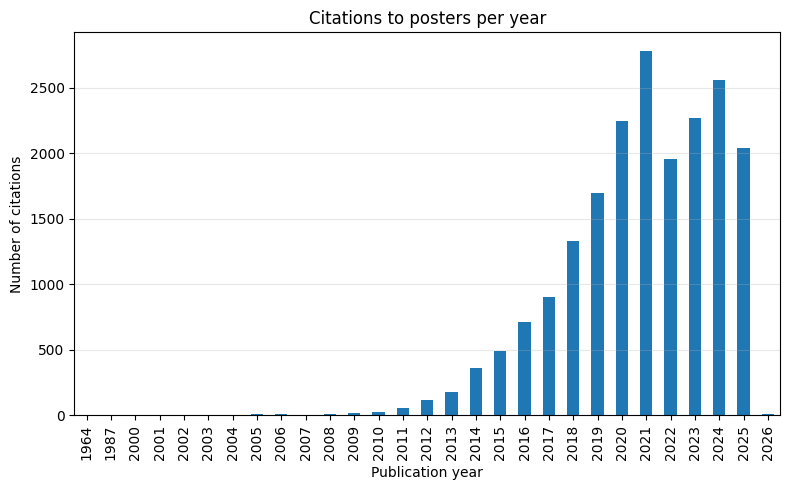

In [11]:
plt.figure(figsize=(8, 5))
citations_per_year.plot(kind="bar")

plt.xlabel("Publication year")
plt.ylabel("Number of citations")
plt.title("Citations to posters per year")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

### Distribution table

In [102]:
def summarize_distribution(df, col):
    s = df[col].dropna()

    # Basic
    out = {
        "posters": int(s.count()),
        "count": float(s.sum()),
        "mean": float(s.mean()),
        "median": float(s.median()),
        "std": float(s.std(ddof=1)),
        "min": float(s.min()),
        "p25": float(s.quantile(0.25)),
        "p75": float(s.quantile(0.75)),
        "p90": float(s.quantile(0.90)),
        "p95": float(s.quantile(0.95)),
        "p99": float(s.quantile(0.99)),
        "max": float(s.max()),
    }

    # Zero inflation - count with zero views/downloads/citations
    n_zero = int((s == 0).sum())
    out["n_zero"] = n_zero
    out["pct_zero"] = 100.0 * n_zero / max(int(s.count()), 1)

    # Specific analysis on posters with non zero engagement
    s_nz = s[s > 0]
    out["n_nonzero"] = int(s_nz.count())
    out["pct_nonzero"] = 100.0 * int(s_nz.count()) / max(int(s.count()), 1)

    if len(s_nz) > 0:
        out["mean_nz"] = float(s_nz.mean())
        out["median_nz"] = float(s_nz.median())
        out["p90_nz"] = float(s_nz.quantile(0.90))
        out["p95_nz"] = float(s_nz.quantile(0.95))
        out["p99_nz"] = float(s_nz.quantile(0.99))
    else:
        out["mean_nz"] = np.nan
        out["median_nz"] = np.nan
        out["p90_nz"] = np.nan
        out["p95_nz"] = np.nan
        out["p99_nz"] = np.nan

    return pd.Series(out)

def top_share(df, col, top_pct):
    s = df[col].dropna()
    total = s.sum()
    if total <= 0:
        return np.nan

    n = len(s)
    k = max(int(np.ceil(top_pct * n)), 1)
    top_sum = s.sort_values(ascending=False).head(k).sum()
    return top_sum / total

summary = pd.DataFrame({
    "views": summarize_distribution(df, "views"),
    "downloads": summarize_distribution(df, "downloads"),
    "citations": summarize_distribution(df, "citations"),
})

# Add concentration rows (shares of total)
for pct in [0.01, 0.05, 0.10]:
    label = f"top_{int(pct*100)}%_share"
    summary.loc[label, "views"] = top_share(df_open, "views", pct) * 100
    summary.loc[label, "downloads"] = top_share(df_open, "downloads", pct) * 100
    summary.loc[label, "citations"] = top_share(df_open, "citations", pct) * 100

# Round up numbers
summary_rounded = summary.copy()
int_like_rows = ["posters", "n_zero", "n_nonzero"]
summary_rounded.loc[int_like_rows] = summary_rounded.loc[int_like_rows].round(0)
summary_rounded = summary_rounded.round(2)

print(summary_rounded)

                    views   downloads  citations
posters          38147.00    38147.00   38147.00
count          9407092.00  4583976.00   19809.00
mean               246.60      120.17       0.52
median              95.00       62.00       0.00
std               1135.18      585.90      30.01
min                  0.00        0.00       0.00
p25                 48.00       29.00       0.00
p75                234.00      129.00       0.00
p90                590.00      276.00       0.00
p95                888.00      408.00       1.00
p99               1966.54      752.00       6.00
max             133644.00   102945.00    5777.00
n_zero            4387.00     4449.00   36068.00
pct_zero            11.50       11.66      94.55
n_nonzero        33760.00    33698.00    2079.00
pct_nonzero         88.50       88.34       5.45
mean_nz            278.65      136.03       9.53
median_nz          111.00       72.00       2.00
p90_nz             642.00      300.30      14.00
p95_nz             9

#### Distribution plots

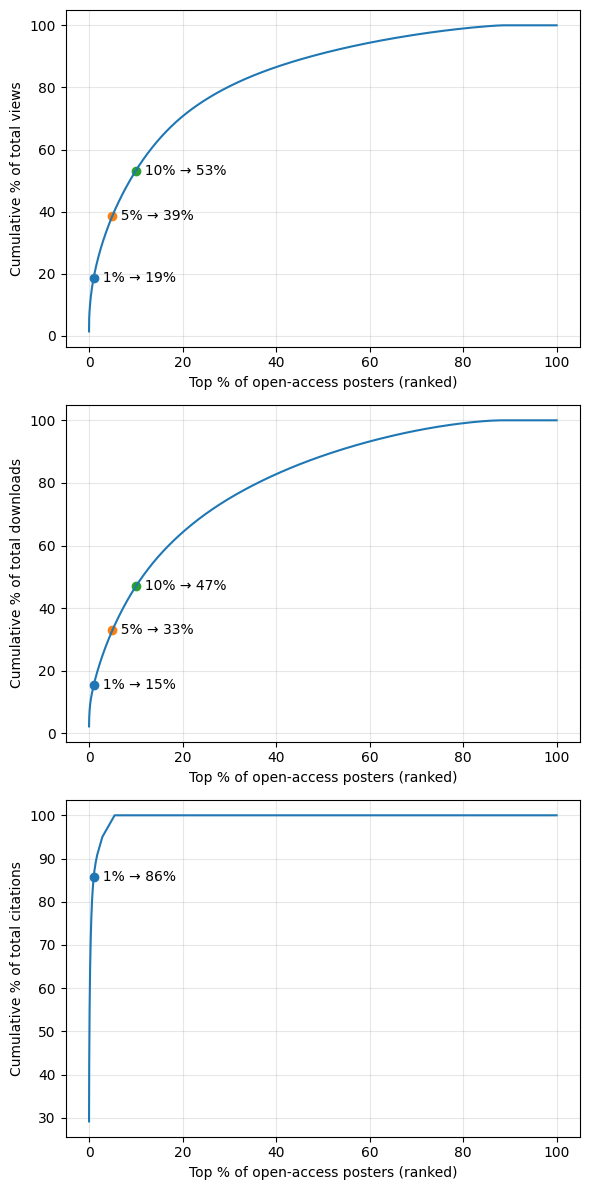

In [103]:
def annotate_top_points(ax, df, col, points=(1, 5, 10)):
    # data
    x = df[col].fillna(0).clip(lower=0).to_numpy()
    x_sorted = np.sort(x)[::-1]

    # handle all-zeros to avoid dividing by zero
    total = x_sorted.sum()
    if total <= 0:
        ax.text(0.5, 0.5, "No data (sum = 0)", ha="center", va="center", transform=ax.transAxes)
        ax.set_xlabel("Top % of posters")
        ax.set_ylabel("Cumulative %")
        ax.grid(True, alpha=0.3)
        return

    cum_share = np.cumsum(x_sorted) / total
    top_pct = np.arange(1, len(x_sorted) + 1) / len(x_sorted)

    # plot
    ax.plot(top_pct * 100, cum_share * 100)
    for p in points:
        idx = int(np.ceil(len(x_sorted) * (p / 100))) - 1
        idx = max(0, min(idx, len(x_sorted) - 1))
        ax.scatter([p], [cum_share[idx] * 100])
        ax.text(p, cum_share[idx] * 100, f"  {p}% → {cum_share[idx]*100:.0f}%", va="center")

    ax.set_xlabel("Top % of open-access posters (ranked)")
    ax.set_ylabel(f"Cumulative % of total {col}")
    ax.grid(True, alpha=0.3)

fig, axes = plt.subplots(3, 1, figsize=(6, 12), sharey=False)

annotate_top_points(axes[0], df, "views", points=(1, 5, 10))
annotate_top_points(axes[1], df, "downloads", points=(1, 5, 10))
annotate_top_points(axes[2], df, "citations", points=(1,))

plt.tight_layout()
plt.savefig('outputs/poster-reuse/distribution-engagement.png') 
plt.show()

### Prepare data for correlation analysis

In [22]:
METADATA_COLS = [
    "authors_affiliation_percentage",
    "authors_orcid_percentage",
    "has_title",
    "has_description",
    "description_words_count",
    "description_characters_count",
    "keywords_freetext_count",
    "keywords_controlled_vocabularies_count",
    "total_keywords_count",
    "has_license",
    "has_funding_info",
    "has_conference_acronym",
    "has_conference_dates",
    "has_conference_place",
    "has_conference_session",
    "has_conference_session_part",
    "has_conference_title",
    "has_conference_website",
    "references_no_identifiers_count",
    "references_with_identifiers_count",
    "total_references_count"
]

OUTCOME_COLS = ["views", "downloads", "citations"]

EXTRA_COLS = ["creation_year", "repository"]

In [23]:
# Keep only column of interest for analysis
ANALYSIS_COLS = METADATA_COLS + OUTCOME_COLS + EXTRA_COLS

missing_cols = [c for c in ANALYSIS_COLS if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing expected columns: {missing_cols}")

df_analysis = (
    df[ANALYSIS_COLS]
    .copy()
    .reset_index(drop=True)
)
print(len(df_analysis))
display(df_analysis.head())

38147


,authors_affiliation_percentage,authors_orcid_percentage,has_title,has_description,description_words_count,description_characters_count,keywords_freetext_count,keywords_controlled_vocabularies_count,total_keywords_count,has_license,...,has_conference_title,has_conference_website,references_no_identifiers_count,references_with_identifiers_count,total_references_count,views,downloads,citations,creation_year,repository
0,0.0,0.0,True,True,109,627,5,0,5,True,...,False,False,0,0,0,157,57,0,2019,Figshare
1,0.0,25.0,True,True,316,1814,4,0,4,True,...,False,False,0,0,0,0,0,0,2019,Figshare
2,0.0,100.0,True,True,22,124,2,0,2,True,...,False,False,0,0,0,139,29,0,2020,Figshare
3,0.0,50.0,True,True,10,62,6,0,6,True,...,False,False,0,0,0,281,61,0,2022,Figshare
4,0.0,0.0,True,True,32,195,7,0,7,True,...,False,False,0,0,0,0,0,0,2020,Figshare


### Check validity and completeness of data

#### Helper

In [24]:
def invalid_boolean(series):
    valid = series.isin([True, False])
    return series[~valid & series.notna()]

def invalid_nonneg_int(series):
    numeric = pd.to_numeric(series, errors="coerce")
    valid = numeric.notna() & (numeric >= 0) & (numeric % 1 == 0)
    return series[~valid & series.notna()]

def invalid_percentage(series):
    numeric = pd.to_numeric(series, errors="coerce")
    valid = numeric.notna() & (numeric >= 0) & (numeric <= 100)
    return series[~valid & series.notna()]

def validate_dataframe(df, cols=None, missing_warn_pct=0.0):

    if cols is None:
        cols = list(dict.fromkeys(BOOL_COLS + COUNT_COLS + PCT_COLS))  # unique, preserve order

    n = len(df)
    issues = []

    # Completeness checks (check for missing values)
    for col in cols:
        n_missing = int(df[col].isna().sum())
        pct_missing = 100.0 * n_missing / max(n, 1)
        if pct_missing >= missing_warn_pct and n_missing > 0:
            issues.append({
                "column": col,
                "check": "completeness",
                "rule": f"missing % < {missing_warn_pct:.2f}%" if missing_warn_pct > 0 else "no missing values",
                "n_problem": n_missing,
                "pct_problem": round(pct_missing, 2),
                "examples": None,
            })

    # Validity checks (check that non-missing values are of valid data type)
    for col in BOOL_COLS:
        if col not in df.columns: 
            continue
        bad = invalid_boolean(df[col])
        if not bad.empty:
            issues.append({
                "column": col,
                "check": "validity",
                "rule": "boolean (True/False)",
                "n_problem": int(len(bad)),
                "pct_problem": round(100.0 * len(bad) / max(n, 1), 2),
                "examples": bad.head(5).tolist(),
            })

    for col in COUNT_COLS:
        if col not in df.columns: 
            continue
        bad = invalid_nonneg_int(df[col])
        if not bad.empty:
            issues.append({
                "column": col,
                "check": "validity",
                "rule": "integer ≥ 0",
                "n_problem": int(len(bad)),
                "pct_problem": round(100.0 * len(bad) / max(n, 1), 2),
                "examples": bad.head(5).tolist(),
            })

    for col in PCT_COLS:
        if col not in df.columns: 
            continue
        bad = invalid_percentage(df[col])
        if not bad.empty:
            issues.append({
                "column": col,
                "check": "validity",
                "rule": "float ∈ [0, 100]",
                "n_problem": int(len(bad)),
                "pct_problem": round(100.0 * len(bad) / max(n, 1), 2),
                "examples": bad.head(5).tolist(),
            })

    report = pd.DataFrame(issues)

    if not report.empty:
        report = report.sort_values(["check", "pct_problem", "column"], ascending=[True, False, True])

    return report

In [25]:
BOOL_COLS = [c for c in METADATA_COLS if c.startswith("has_")]
COUNT_COLS = (
    [c for c in METADATA_COLS if c.endswith("_count")]
    + OUTCOME_COLS
)
PCT_COLS = [c for c in METADATA_COLS if c.endswith("_percentage")]

report = validate_dataframe(df, missing_warn_pct=0.0)
if report.empty:
    print("All the data is complete (non-empty) and valid (data types are as expected)")
else:
    report

All the data is complete (non-empty) and valid (data types are as expected)
